In [1]:
from utils.llm_provider import LLMProvider
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os

GOOGLE_MODEL_ID = os.environ["DEFAULT_MODEL"]
GOOGLE_FALLBACK_MODEL_ID = os.environ["ANOTHER_FALLBACK_MODEL"]
EMBEDDING_MODEL = os.environ["EMBEDDING_MODEL"]

GROQ_FALLBACK_MODEL_ID = os.environ["DEFAULT_FALLBACK_GROQ_MODEL"]
GROQ_TOOLCALL_MODEL_ID = os.environ["ANOTHER_FALLBACK_GROQ_MODEL"]

google_lm = LLMProvider(
    model_id=GOOGLE_MODEL_ID,
    provider="google",
).get_llm(max_tokens=4084, temperature=0.2)
google_fblm = LLMProvider(
    model_id=GOOGLE_FALLBACK_MODEL_ID,
    provider="google",
).get_llm(max_tokens=4084, temperature=0.2)
embed_lm = LLMProvider(
    model_id=EMBEDDING_MODEL,
    provider="google",
).get_embed_lm()


groq_lm = LLMProvider().get_llm(max_tokens=4084)
groq_fblm = LLMProvider(
    model_id=GROQ_FALLBACK_MODEL_ID,
    provider="groq",
).get_llm(max_tokens=4084)
groq_tool_lm = LLMProvider(
    model_id=GROQ_TOOLCALL_MODEL_ID,
    provider="groq",
).get_llm(max_tokens=4084)

List of llms we have access to, atm!

```python

llms = {
    "google": [
                google_lm,
                google_fblm,
                embed_lm,
            ],
    "groq": [
                groq_lm,
                groq_fblm,
                groq_tool_lm,
            ],
}

```

#### 1. Simple Graph

In [4]:
from typing import TypedDict

class State(TypedDict):
    graph_state: str

##### Nodes

In [5]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state["graph_state"] + "I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state["graph_state"] + " happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state["graph_state"] + " sad!"}

##### Edges

In [6]:
import random
from typing import Literal

def decide_mood(state) -> Literal['node_2', 'node_3']:
    user_input = state["graph_state"]

    if random.random() < 0.5:
        return "node_2"
    
    return "node_3"

##### Graph construction

In [7]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges(
    "node_1", decide_mood
    )
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

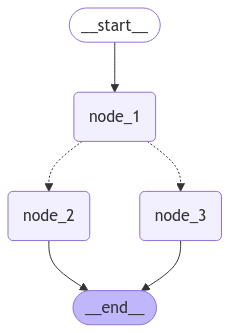

In [8]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"graph_state": "rinzler, fights for the users. I'm CLU. "})

---Node 1---
---Node 2---


{'graph_state': "rinzler, fights for the users. I'm CLU. I am happy!"}

In [12]:
graph.invoke({"graph_state": "rinzler, fights for the users. I'm CLU. "})

---Node 1---
---Node 3---


{'graph_state': "rinzler, fights for the users. I'm CLU. I am sad!"}

#### 2. Chain

We'll try to basically involve the following concepts:  
- chat models
- binding tools to LLM
- executing tool calls in the graph

##### Messages

In [14]:
# from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content="So, you said you were wondering how adding a VPN service / a private tunnel, improves the security of an SSH connection?", name="CLU")]
messages.extend([HumanMessage(content="Yes, that's true. I recall reading somewhere that the VPN services do not respond back when authentication fails. Not really sure about the authenticity of this theory, though!", name="rinzler")])
messages.extend([AIMessage(content="Oh, that's interesting. Perhaps I can help you with that. Would you like any help understanding this topic better?", name="CLU")])
messages.extend([HumanMessage(content="That would be great, yes.", name="rinzler")])

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: CLU

So, you said you were wondering how adding a VPN service / a private tunnel, improves the security of an SSH connection?
================================ Human Message =================================
Name: rinzler

Yes, that's true. I recall reading somewhere that the VPN services do not respond back when authentication fails. Not really sure about the authenticity of this theory, though!
================================== Ai Message ==================================
Name: CLU

Oh, that's interesting. Perhaps I can help you with that. Would you like any help understanding this topic better?
================================ Human Message =================================
Name: rinzler

That would be great, yes.


##### Chat Models

Not worrying about importing model related libs, and loading the API key, since that's already taken care of in the earlier parts of the notebook;  
and also in the `utils/llm_provider` module.

In [15]:
result = google_lm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [16]:
result

AIMessage(content='The statement "VPN services do not respond back when authentication fails" is **partially true but misleading and doesn\'t fully explain the security benefits**.  Let\'s break it down:\n\n**What\'s actually happening:**\n\n* **Standard SSH:** When you connect to an SSH server, your authentication attempt (username/password or key) is sent directly to the server.  If it fails, the server sends a rejection message back to you.  This exchange is visible to anyone passively monitoring the network traffic (e.g., a man-in-the-middle attacker).  They can see your username and potentially deduce other information from the failure response.\n\n* **SSH over VPN:** When you connect to an SSH server *through* a VPN, your SSH traffic is encrypted within the VPN tunnel.  The authentication attempt is still sent to the SSH server, but the entire communication (including the failure response) is encrypted.  A passive attacker on the network only sees encrypted data; they can\'t see 

In [17]:
from IPython.display import display, Markdown
display(Markdown(result.content))

The statement "VPN services do not respond back when authentication fails" is **partially true but misleading and doesn't fully explain the security benefits**.  Let's break it down:

**What's actually happening:**

* **Standard SSH:** When you connect to an SSH server, your authentication attempt (username/password or key) is sent directly to the server.  If it fails, the server sends a rejection message back to you.  This exchange is visible to anyone passively monitoring the network traffic (e.g., a man-in-the-middle attacker).  They can see your username and potentially deduce other information from the failure response.

* **SSH over VPN:** When you connect to an SSH server *through* a VPN, your SSH traffic is encrypted within the VPN tunnel.  The authentication attempt is still sent to the SSH server, but the entire communication (including the failure response) is encrypted.  A passive attacker on the network only sees encrypted data; they can't see the username, password, or the success/failure of the authentication.

**Why the statement is misleading:**

The VPN itself *does* respond.  It establishes a secure connection with your device and the VPN server.  The VPN server then acts as a gateway, forwarding your SSH traffic.  The VPN server *will* respond to your connection request, and it will respond to the SSH server's authentication response.  The key is that *these responses are encrypted*.

The statement likely refers to the fact that the *SSH server's rejection message* isn't directly visible to the attacker.  The attacker only sees encrypted data flowing between your device and the VPN server.  The VPN server handles the decrypted communication with the SSH server.

**The real security benefits of using a VPN with SSH:**

* **Encryption:** The primary benefit is the encryption of all traffic within the VPN tunnel. This protects against eavesdropping and man-in-the-middle attacks.  Even if the SSH connection itself is compromised (a weak key, for example), the VPN adds an extra layer of security.

* **Obscured Destination:** The VPN hides your real IP address.  The SSH server only sees the IP address of the VPN server, making it harder to trace the connection back to you.

* **Protection against DNS leaks:**  A VPN can prevent DNS leaks, ensuring that your DNS queries are also encrypted and routed through the VPN.

**In short:**  A VPN doesn't prevent the SSH server from responding to authentication attempts.  Instead, it encrypts the entire communication, including the responses, making it unreadable to eavesdroppers.  This is the crucial security improvement.

In [18]:
result.usage_metadata

{'input_tokens': 92,
 'output_tokens': 558,
 'total_tokens': 650,
 'input_token_details': {'cache_read': 0}}

In [20]:
result.model_dump_json()

'{"content":"The statement \\"VPN services do not respond back when authentication fails\\" is **partially true but misleading and doesn\'t fully explain the security benefits**.  Let\'s break it down:\\n\\n**What\'s actually happening:**\\n\\n* **Standard SSH:** When you connect to an SSH server, your authentication attempt (username/password or key) is sent directly to the server.  If it fails, the server sends a rejection message back to you.  This exchange is visible to anyone passively monitoring the network traffic (e.g., a man-in-the-middle attacker).  They can see your username and potentially deduce other information from the failure response.\\n\\n* **SSH over VPN:** When you connect to an SSH server *through* a VPN, your SSH traffic is encrypted within the VPN tunnel.  The authentication attempt is still sent to the SSH server, but the entire communication (including the failure response) is encrypted.  A passive attacker on the network only sees encrypted data; they can\'t 

In [21]:
result.model_dump()

{'content': 'The statement "VPN services do not respond back when authentication fails" is **partially true but misleading and doesn\'t fully explain the security benefits**.  Let\'s break it down:\n\n**What\'s actually happening:**\n\n* **Standard SSH:** When you connect to an SSH server, your authentication attempt (username/password or key) is sent directly to the server.  If it fails, the server sends a rejection message back to you.  This exchange is visible to anyone passively monitoring the network traffic (e.g., a man-in-the-middle attacker).  They can see your username and potentially deduce other information from the failure response.\n\n* **SSH over VPN:** When you connect to an SSH server *through* a VPN, your SSH traffic is encrypted within the VPN tunnel.  The authentication attempt is still sent to the SSH server, but the entire communication (including the failure response) is encrypted.  A passive attacker on the network only sees encrypted data; they can\'t see the us

<div class="alert-block alert" style="background-color: #ed2c14; color: #fff;">

Well, what about Groq models, then?

</div>

In [22]:
groq_result = groq_lm.invoke(messages)
type(groq_result)

langchain_core.messages.ai.AIMessage

In [23]:
groq_result

AIMessage(content="When you connect to a VPN (Virtual Private Network), it creates a secure tunnel between your device and the VPN server. This tunnel encrypts all your internet traffic, making it difficult for anyone to intercept or eavesdrop on your data.\n\nNow, when you're using a VPN to connect to an SSH server (Secure Shell), the VPN server acts as an intermediary between your device and the SSH server. This means that your device doesn't directly connect to the SSH server; instead, it connects to the VPN server, which then forwards your traffic to the SSH server.\n\nRegarding your question about authentication failures, here's what happens:\n\n1. When you try to connect to the SSH server through the VPN, your device sends a request to the VPN server.\n2. The VPN server forwards this request to the SSH server.\n3. If the authentication fails (e.g., you enter the wrong password), the SSH server will respond with an error message to the VPN server.\n4. However, the VPN server will 

In [24]:
from IPython.display import display, Markdown
display(Markdown(groq_result.content))

When you connect to a VPN (Virtual Private Network), it creates a secure tunnel between your device and the VPN server. This tunnel encrypts all your internet traffic, making it difficult for anyone to intercept or eavesdrop on your data.

Now, when you're using a VPN to connect to an SSH server (Secure Shell), the VPN server acts as an intermediary between your device and the SSH server. This means that your device doesn't directly connect to the SSH server; instead, it connects to the VPN server, which then forwards your traffic to the SSH server.

Regarding your question about authentication failures, here's what happens:

1. When you try to connect to the SSH server through the VPN, your device sends a request to the VPN server.
2. The VPN server forwards this request to the SSH server.
3. If the authentication fails (e.g., you enter the wrong password), the SSH server will respond with an error message to the VPN server.
4. However, the VPN server will not respond to your device with the error message. Instead, it will simply close the connection.

This is because the VPN server doesn't send any error messages back to your device. It only forwards the error message to the VPN server, which then closes the connection.

This behavior is a security feature of VPNs. By not responding to authentication failures, VPNs prevent attackers from determining whether a username or password is valid or not. This makes it more difficult for attackers to conduct brute-force attacks or dictionary attacks on your SSH server.

So, to summarize, the theory you read is correct: VPNs don't respond to authentication failures, which makes it harder for attackers to determine whether a username or password is valid or not.

In [25]:
groq_result.usage_metadata

{'input_tokens': 140, 'output_tokens': 348, 'total_tokens': 488}

In [26]:
groq_result.model_dump()

{'content': "When you connect to a VPN (Virtual Private Network), it creates a secure tunnel between your device and the VPN server. This tunnel encrypts all your internet traffic, making it difficult for anyone to intercept or eavesdrop on your data.\n\nNow, when you're using a VPN to connect to an SSH server (Secure Shell), the VPN server acts as an intermediary between your device and the SSH server. This means that your device doesn't directly connect to the SSH server; instead, it connects to the VPN server, which then forwards your traffic to the SSH server.\n\nRegarding your question about authentication failures, here's what happens:\n\n1. When you try to connect to the SSH server through the VPN, your device sends a request to the VPN server.\n2. The VPN server forwards this request to the SSH server.\n3. If the authentication fails (e.g., you enter the wrong password), the SSH server will respond with an error message to the VPN server.\n4. However, the VPN server will not re

##### Tools

I'm going to build a git add to index, and commit tool.  
Instead of doing the rhetoric usual stuff, where we provide the llm with functions that perform basic arithmetic operations, let's have some fun!

In [27]:
# TODO: make method / tool_call accept param, that gets the repo path, to then check and run the commands at!
# This is a very trivial improvement, won't take much effort.
# Just get the path to repo in the method as a param, do os.chdir() to that path, and then continue!

import os
from pathlib import Path

def add_and_commit_changes(repo_local_path: str = ".") -> bool:
    """
    Method to check if there are any changes to repository.
    If there are changes, then generate commit message, appropriate to the changes made.
    Commit changes after adding them to the staging area.

    Args:
        repo_local_path (str): Path to the local repository. Defaults to current directory.

    Returns:
        bool: True if changes were committed successfully, False otherwise.
    """
    print("___"*10)
    print("Git commit tool call, invoked!!!")
    print("___"*10)

    os.chdir(repo_local_path)

    import subprocess
    from langchain_core.messages import HumanMessage, SystemMessage
    # capture the output of the process!
    print("`>$ git status` ...")
    result = subprocess.run(["git", "status"], capture_output=True, text=True)

    output = result.stdout

    if "nothing to commit, working tree clean" in output.lower():
        print("No changes to be committed!")
        return False
    
    print(output)
    
    res = subprocess.run(["git", "diff", "HEAD"], capture_output=True, text=True)
    diff = res.stdout

    bres = subprocess.run(["git", "branch", "--show-current"], capture_output=True, text=True)
    branch = bres.stdout
    l10c_res = subprocess.run(["git", "log", "-n", "10", "--oneline"], capture_output=True, text=True)
    log10commits = l10c_res.stdout

    messages = [
        SystemMessage(content="You are a senior developer, who is experienced with Git and Distributed Version control systems. You are also fairly proficient in articulating technical specifics in english, for anyone to read and comprehend."),
        HumanMessage(content=f"Given the following diff from previous commit:\n {diff}", name="rinzler"),
        HumanMessage(content=f"\nGiven the following branch name: {branch}", name="rinzler"),
        HumanMessage(content=f"\nGiven the following log of last 10 commits: {log10commits}", name="rinzler"),
        HumanMessage(content="Generate a commit message, that would be relevant to the changes made in the repository!", name="rinzler")
    ]
    
    commit = google_lm.invoke(messages)
    commit_msg = commit.content

    print(f"Committing changes with message: {commit_msg}")
    subprocess.run(["git", "add", "."])
    subprocess.run(["git", "commit", "-m", commit_msg])
    print("Changes committed successfully!")
    return True

In [28]:
tool_access_lm = groq_tool_lm.bind_tools([add_and_commit_changes])

In [29]:
tool_call_res_test1 = tool_access_lm.invoke("What can you tell me about the learned helplessness theory?")
tool_call_res_test1

BadRequestError: Error code: 400 - {'error': {'message': 'The model `llama3-groq-8b-8192-tool-use-preview` has been decommissioned and is no longer supported. Please refer to https://console.groq.com/docs/deprecations for a recommendation on which model to use instead.', 'type': 'invalid_request_error', 'code': 'model_decommissioned'}}

In [30]:
groq_tool_llm = LLMProvider(
    provider="groq",
    model_id="llama-3.1-8b-instant"
).get_llm(max_tokens=4084)

tool_access_lm = groq_tool_llm.bind_tools([add_and_commit_changes])

In [31]:
tool_call_res_test1 = tool_access_lm.invoke("What can you tell me about the learned helplessness theory?")
tool_call_res_test1

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tdjv', 'function': {'arguments': '{"query": "learned helplessness theory"}', 'name': 'brave_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 304, 'total_tokens': 324, 'completion_time': 0.026666667, 'prompt_time': 0.014557366, 'queue_time': 0.23493254800000002, 'total_time': 0.041224033}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4a6201cbac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-239fdb99-680b-4d02-92e4-e136f955d0d1-0', tool_calls=[{'name': 'brave_search', 'args': {'query': 'learned helplessness theory'}, 'id': 'call_tdjv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 304, 'output_tokens': 20, 'total_tokens': 324})

In [35]:
tool_call_res_test1.model_dump()

{'content': '',
 'additional_kwargs': {'tool_calls': [{'id': 'call_tdjv',
    'function': {'arguments': '{"query": "learned helplessness theory"}',
     'name': 'brave_search'},
    'type': 'function'}]},
 'response_metadata': {'token_usage': {'completion_tokens': 20,
   'prompt_tokens': 304,
   'total_tokens': 324,
   'completion_time': 0.026666667,
   'prompt_time': 0.014557366,
   'queue_time': 0.23493254800000002,
   'total_time': 0.041224033},
  'model_name': 'llama-3.1-8b-instant',
  'system_fingerprint': 'fp_4a6201cbac',
  'finish_reason': 'tool_calls',
  'logprobs': None},
 'type': 'ai',
 'name': None,
 'id': 'run-239fdb99-680b-4d02-92e4-e136f955d0d1-0',
 'example': False,
 'tool_calls': [{'name': 'brave_search',
   'args': {'query': 'learned helplessness theory'},
   'id': 'call_tdjv',
   'type': 'tool_call'}],
 'invalid_tool_calls': [],
 'usage_metadata': {'input_tokens': 304,
  'output_tokens': 20,
  'total_tokens': 324}}

In [32]:
tool_call_res_test = tool_access_lm.invoke("Check if there are changes to the repository in the current working directory, and commit them if there are any.")

In [33]:
tool_call_res_test

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m5c1', 'function': {'arguments': '{"repo_local_path": "."}', 'name': 'add_and_commit_changes'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 314, 'total_tokens': 330, 'completion_time': 0.021333333, 'prompt_time': 0.010520338, 'queue_time': 0.235636116, 'total_time': 0.031853671}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4a6201cbac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-259152f5-c114-4c32-8045-cd9b2db5669f-0', tool_calls=[{'name': 'add_and_commit_changes', 'args': {'repo_local_path': '.'}, 'id': 'call_m5c1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 314, 'output_tokens': 16, 'total_tokens': 330})

In [34]:
tool_call_res_test.tool_calls

[{'name': 'add_and_commit_changes',
  'args': {'repo_local_path': '.'},
  'id': 'call_m5c1',
  'type': 'tool_call'}]

<div class="alert alert-block" style="background-color: #5c66f0; color: #fff;">

So, **groq's** models aren't able to tell apart when there's no need to perform a tool call.  
They're however able to tell, when there's a need to make a tool_call!  

</div>

<div class="alert alert-block" style="background-color: #4bb552; color: #fff;">

Let's try Gemini Models, see how they fare!

</div>

In [36]:
gemini_tool_lm = google_lm.bind_tools([add_and_commit_changes])

In [37]:
g_tool_call_res_test1 = gemini_tool_lm.invoke("What can you tell me about the learned helplessness theory?")
g_tool_call_res_test1

AIMessage(content="Learned helplessness is a psychological phenomenon where an organism, after experiencing repeated inescapable aversive stimuli, fails to learn or utilize effective escape or avoidance responses even when such responses are readily available.  Essentially, the organism learns that its actions have no effect on its environment, leading to passivity and a sense of hopelessness.\n\nThis theory was developed by Martin Seligman and colleagues through experiments with dogs.  Dogs subjected to inescapable shocks eventually stopped attempting to escape even when given the opportunity to do so later.  This passivity extended beyond the experimental context, impacting their behavior in other situations.\n\nThe key elements of learned helplessness are:\n\n* **Inescapable aversive stimuli:**  The organism experiences negative events that it cannot control.\n* **Attribution of uncontrollability:** The organism attributes the negative events to internal, stable, and global factors.

In [39]:
g_tool_call_res_test1.model_dump()

{'content': "Learned helplessness is a psychological phenomenon where an organism, after experiencing repeated inescapable aversive stimuli, fails to learn or utilize effective escape or avoidance responses even when such responses are readily available.  Essentially, the organism learns that its actions have no effect on its environment, leading to passivity and a sense of hopelessness.\n\nThis theory was developed by Martin Seligman and colleagues through experiments with dogs.  Dogs subjected to inescapable shocks eventually stopped attempting to escape even when given the opportunity to do so later.  This passivity extended beyond the experimental context, impacting their behavior in other situations.\n\nThe key elements of learned helplessness are:\n\n* **Inescapable aversive stimuli:**  The organism experiences negative events that it cannot control.\n* **Attribution of uncontrollability:** The organism attributes the negative events to internal, stable, and global factors.  This

In [38]:
g_tool_call_res_test2 = gemini_tool_lm.invoke("Check if there are changes to the repository in the current working directory, and commit them if there are any.")
g_tool_call_res_test2

AIMessage(content='', additional_kwargs={'function_call': {'name': 'add_and_commit_changes', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6f6b11ce-937e-471f-b321-1f5c578f137c-0', tool_calls=[{'name': 'add_and_commit_changes', 'args': {}, 'id': 'e59d1a8b-df07-430a-a504-222c0c43e0bc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 7, 'total_tokens': 91, 'input_token_details': {'cache_read': 0}})

In [40]:
g_tool_call_res_test2.tool_calls

[{'name': 'add_and_commit_changes',
  'args': {},
  'id': 'e59d1a8b-df07-430a-a504-222c0c43e0bc',
  'type': 'tool_call'}]

```
Stopped at 2:43 of the "Lesson 4: Chain" in LC Academy!
```

###### Trying to see if tool_node can be invoked!

In [42]:
from langgraph.graph import MessagesState

def tool_call_func(state: MessagesState):
    print("---Tool Call Function---")
    response = gemini_tool_lm.invoke(state["messages"])
    state["messages"].append(response)
    return state


In [44]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

# Nodes
builder.add_node("tool_call_func", tool_call_func)
builder.add_node("tools", ToolNode([add_and_commit_changes]))

# Edges
builder.add_edge(START, "tool_call_func")
builder.add_conditional_edges("tool_call_func", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()

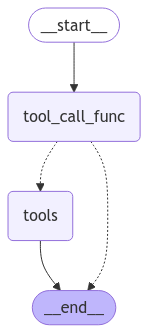

In [45]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
state: MessagesState = MessagesState()
state["messages"] = [HumanMessage(content="Check if there are changes to the repository in the current working directory, and commit them if there are any.", name="rinzler")]

In [ ]:
tool_exec_trial = graph.invoke(state)

---Tool Call Function---


In [ ]:
for res in tool_exec_trial:
    res.pretty_print()

###### End of tool calling graph trial!